In [69]:
import os
# os.chdir('/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd')
# os.chdir('/Users/mc/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd')

import dLux as dl

import jax.scipy as jsp
import matplotlib.pyplot as plt
import matplotlib as mpl
import dLuxToliman as dlT
import zodiax as zdx
import optax
from jax import numpy as np
from jax import Array
import jax
from tqdm.notebook import tqdm

# import ehtplot
import scienceplots
import cmasher as cmr
plt.style.use(["science", "no-latex"])

%matplotlib inline
plt.rcParams['image.cmap'] = 'magma'
# plt.rcParams["font.family"] = "monospace"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 300
# plt.rcParams['xtick.direction'] = 'out'
# plt.rcParams['ytick.direction'] = 'out'

# Enable 64bit precision (note this must be run in the first cell of the notebook)
jax.config.update("jax_enable_x64", True)

ito_seven = ["#0072B2", "#D55E00", "#009E73", "#CC79A7", "#56B4E9", "#E69F00", "#F0E442"]
contrast_three = ["#004488", "#BB5566", "#DDAA33"]

# Creating a jittered instrument
Using new class `dlT.JitteredToliman` 

In [10]:

# jax
import dLuxToliman as dlT
import dLux
from dLuxToliman import AlphaCen
import jax
from jax import numpy as np, Array
import jax.scipy as jsp

import zodiax as zdx
from zodiax import filter_vmap

# from setup_jitter import AlphaCenMeanWavel

def setup_jitter(
    angle=0.,
    mag=0.5*0.375,
    shear=0.2,
    r=0.25e-4,
    oversample=4,
    norm_osamp=6,
    det_pscale=0.375,
    # det_pscale=0.5,
    det_npixels=128,
    kernel_size=17,
    n_psfs=5,
    # source=AlphaCen,
    prior_fn=lambda model: np.array(0.),
    ):

    lin_params = {"jitter_mag": mag, "jitter_angle": angle, "jitter_shape": 'linear', "n_psfs": n_psfs}
    shm_params = {"jitter_mag": mag, "jitter_angle": angle, "jitter_shape": 'shm', "n_psfs": n_psfs}
    norm_params = {"r": r, "shear": shear, "phi": angle, "kernel_size": kernel_size}
    radial_orders = [2, 3]

    # Creating common optical system
    optics = dlT.TolimanOpticalSystem(
        oversample=oversample,
        psf_npixels=det_npixels,
        radial_orders=radial_orders,
        psf_pixel_scale=det_pscale,
        )

    optics = optics.divide('aperture.basis', 1e9) # Set basis units to nanometers
    norm_optics = optics.set("oversample", norm_osamp)

    # Creating common source
    src = AlphaCen(
        separation=np.array(10.),
        position_angle=np.array(90.),
        # position_angle=np.array(0.),
        # position_angle=np.array(90. + 1e-1),
        x_position=np.array(0.),
        y_position=np.array(0.),
        log_flux=np.array(6.832),
        contrast=np.array(3.37),
    )

    # creating telescopes
    lin_det = dLux.LayeredDetector([('Downsample', dLux.Downsample(oversample))])
    shm_det = lin_det
    norm_det = dLux.LayeredDetector([
        ('Jitter', dlT.GaussianJitter(**norm_params)),
        ('Downsample', dLux.Downsample(norm_osamp)),
    ])

    lin_tel = dlT.JitteredToliman(source=src, optics=optics, **lin_params).set('detector', lin_det)
    shm_tel = dlT.JitteredToliman(source=src, optics=optics, **shm_params).set('detector', shm_det)
    norm_tel = dlT.Toliman(source=src, optics=norm_optics).set('detector', norm_det)

    # creating simulated data
    lin_data = (lin_tel.set(["oversample", "Downsample.kernel_size"], [8, 8])).jitter_model()
    shm_data = (shm_tel.set(["oversample", "Downsample.kernel_size"], [8, 8])).jitter_model()
    norm_data = (norm_tel.set(["oversample", "Downsample.kernel_size"], [8, 8])).model()
    # setting norm_tel to a reasonable oversample
    # norm_tel = norm_tel.set(['oversample', "Downsample.kernel_size"], 2*[oversample])

    # jitter_posterior_fn = lambda model, data: jsp.stats.poisson.logpmf(data, model.jitter_model()).sum() + prior_fn(model)
    def posterior_fn(model, data):
        likelihood = jsp.stats.poisson.logpmf(np.round(data), model.jitter_model()).sum()
        prior = prior_fn(model)
        # print(likelihood, prior)
        return likelihood + prior
    
    # model_fn = lambda model, data: jsp.stats.poisson.logpmf(data, model.model()).sum()
    norm_posterior_fn = lambda model, data: jsp.stats.poisson.logpmf(np.round(data), model.model()).sum() + prior_fn(model)
    
    calc_cov = lambda model, data, parameters: zdx.covariance_matrix(model, parameters, posterior_fn, data, shape_dict={'wavelengths': 1})
    norm_calc_cov = lambda model, data, parameters: zdx.covariance_matrix(model, parameters, norm_posterior_fn, data, shape_dict={'wavelengths': 1})

    models = {"lin": lin_tel, "shm": shm_tel, "norm": norm_tel}
    loglike_fns = {'lin': posterior_fn, 'shm': posterior_fn, "norm": norm_posterior_fn}
    datas = {
        'lin': lin_data,
        'shm': shm_data,
        "norm": norm_data,
        }

    common_params = [
        'separation',
        'position_angle',
        'x_position',
        'y_position',
        'log_flux',
        'contrast',
        'wavelengths',
        'psf_pixel_scale',  
    ]

    lin_params = [
        'jitter_mag',
        'jitter_angle',
        'aperture.coefficients',
    ]

    norm_params = [
        'Jitter.r',
        'Jitter.shear',
        'Jitter.phi',
        'aperture.coefficients',
    ]

    params = {
        "lin": common_params + lin_params,
        "shm": common_params + lin_params,
        "norm": common_params + norm_params,
    }

    cov_fns = {
        "lin": zdx.filter_jit(calc_cov),
        "shm": zdx.filter_jit(calc_cov),
        "norm": zdx.filter_jit(norm_calc_cov),
    }

    return models, datas, params, loglike_fns, cov_fns

In [11]:
# from setup_jitter import setup_jitter

# true_eff_wavel = 585.  # nm
# wavel_precision = 50  # nm

# def wavel_prior(model, truth=true_eff_wavel, sigma=wavel_precision):
#     """
#     Prior on the mean wavelength of the model in nm.
#     """
#     return jsp.stats.norm.logpdf(model.mean_wavelength, truth, sigma)

# def plate_scale_prior(model, truth=0.375, sigma=0.0000375):
#     return jsp.stats.norm.logpdf(model.psf_pixel_scale, truth, sigma)

# def prior_fn(model):
#     return wavel_prior(model) + plate_scale_prior(model)

models, datas, params, loglike_fns, cov_fns = setup_jitter(
    oversample=4,
    n_psfs=5,
    # prior_fn=prior_fn,
    )

# print(models['lin'].wavelengths.mean() == true_eff_wavel)


2024-12-21 15:09:10.630384: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng2{k2=1,k3=0} for conv (f64[1,1,1024,1024]{3,2,1,0}, u8[0]{0}) custom-call(f64[1,1,1024,1024]{3,2,1,0}, f64[1,1,17,17]{3,2,1,0}), window={size=17x17 pad=8_8x8_8}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-12-21 15:09:13.244289: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 3.614010831s
Trying algorithm eng2{k2=1,k3=0} for conv (f64[1,1,1024,1024]{3,2,1,0}, u8[0]{0}) custom-call(f64[1,1,1024,1024]{3,2,1,0}, f64[1,1,17,17]{3,2,1,0}), window={size=17x17 pad=8_8x8_8}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activat

# Fisher Sweeping

In [4]:
def fisher_sweep(
        tel,
        cov_fn,
        params,
        mags=np.linspace(1e-4, 2 * 0.375, 10),
        angs=np.linspace(0, 90, 3),
    ):

    seps = []

    # looping over jitter magnitude
    for mag_idx, mag in tqdm(enumerate(mags), total=len(mags)):
        model = tel.set("jitter_mag", mag)

        # looping over jitter angle
        for ang_idx, ang in enumerate(angs):        
            model = model.set("jitter_angle", ang)
            data = model.jitter_model()

            # calculate covariance matrix
            cov = cov_fn(model, np.round(data), params)

            # read separation from covariance matrix
            sep = np.sqrt(np.abs(cov[0, 0]))
            seps.append(sep)

            # check for NaNs
            if np.isnan(sep).any():
                print(f"NaNs found at mag_idx={mag_idx}, ang_idx={ang_idx}")
                raise ValueError

    seps = np.array(seps).reshape(len(mags), len(angs))
    return seps

In [4]:
# Marginal parameters
params = [
    'separation',
    'position_angle',
    'x_position',
    'y_position',
    'log_flux',
    'contrast',
    'jitter_mag',
    'jitter_angle',
    'aperture.coefficients',
    # 'wavelengths',
    # 'psf_pixel_scale',  
]

# test_mags = np.linspace(0.53, 0.62, 10)
test_mags = np.linspace(1e-4, 2 * 0.375, 30)
# test_angs = np.array([90,])
test_angs = np.linspace(0, 90, 7)
# test_angs = np.linspace(82, 90, 4)


In [8]:
# def cov_to_corr(cov_matrix):

#     # Compute standard deviations (sqrt of diagonal)
#     std_devs = np.sqrt(np.diag(cov_matrix))

#     # Outer product of std_devs gives the denominator for normalization
#     denominator = np.outer(std_devs, std_devs)

#     # Compute the correlation matrix
#     correlation_matrix = cov_matrix / denominator

#     return correlation_matrix

# # # # # testing
# tester = cov_fns["lin"](models["lin"], np.round(datas["lin"]), params)
# # print(tester)

# # np.save("tester.npy", tester)

# correlation = cov_to_corr(tester)
# plt.figure(figsize=(9, 6))
# plt.imshow(
#     correlation,
#     origin='upper',
#     cmap="seismic",
#     norm=mpl.colors.CenteredNorm(),
#     )
# plt.colorbar(label="Correlation Coefficient")
# for j, lab in enumerate(params):
#     plt.scatter(j, j, label=lab)
# plt.axis('off')
# plt.title("Correlation Matrix")
# plt.legend()
# plt.show()



In [68]:
seps_lin = fisher_sweep(
    # models["lin"].set("detector", None),
    # models["lin"].set("detector", None).jitter_model(),
    # models["lin"].set(["Downsample.kernel_size", "oversample"], [3, 3]),
    models["lin"],
    cov_fns["lin"],
    params,
    # mags=np.linspace(1e-4, 2 * 0.375, 10)
    mags=test_mags,
    angs=test_angs,
    )


  0%|          | 0/30 [00:00<?, ?it/s]

In [69]:
seps_shm = fisher_sweep(
    models["shm"],
    cov_fns["shm"],
    params,
    mags=test_mags,
    angs=test_angs,
    )


  0%|          | 0/30 [00:00<?, ?it/s]

In [52]:
stable_model = models["lin"].set("jitter_mag", np.array(0.))
stable_data = stable_model.jitter_model()
stable_cov = cov_fns["lin"](stable_model, np.round(stable_data), params)
baseline = np.sqrt(np.abs(stable_cov[0, 0]))
print(f"Baseline with no wavelengths or pixel scale: {1000 * baseline} as")

Baseline with no wavelengths or pixel scale: 0.5883658744979262 as


In [71]:
# np.save("files/seps/seps_lin_no.npy", seps_lin)
# np.save("files/seps/seps_shm_no.npy", seps_shm)
# # np.save("files/seps/seps_lin_nowl.npy", seps_lin)
# # np.save("files/seps/seps_shm_nowl.npy", seps_shm)

In [2]:
seps_lin = np.load("files/seps/seps_lin_no.npy")
seps_shm = np.load("files/seps/seps_shm_no.npy")
# seps_shm = np.load("files/seps/seps_shm.npy")
# seps_lin = np.load("files/seps/seps_lin_nowl.npy")
# seps_shm = np.load("files/seps/seps_shm_nowl.npy")
# seps_lin = np.load("files/seps/seps_lin_no.npy")

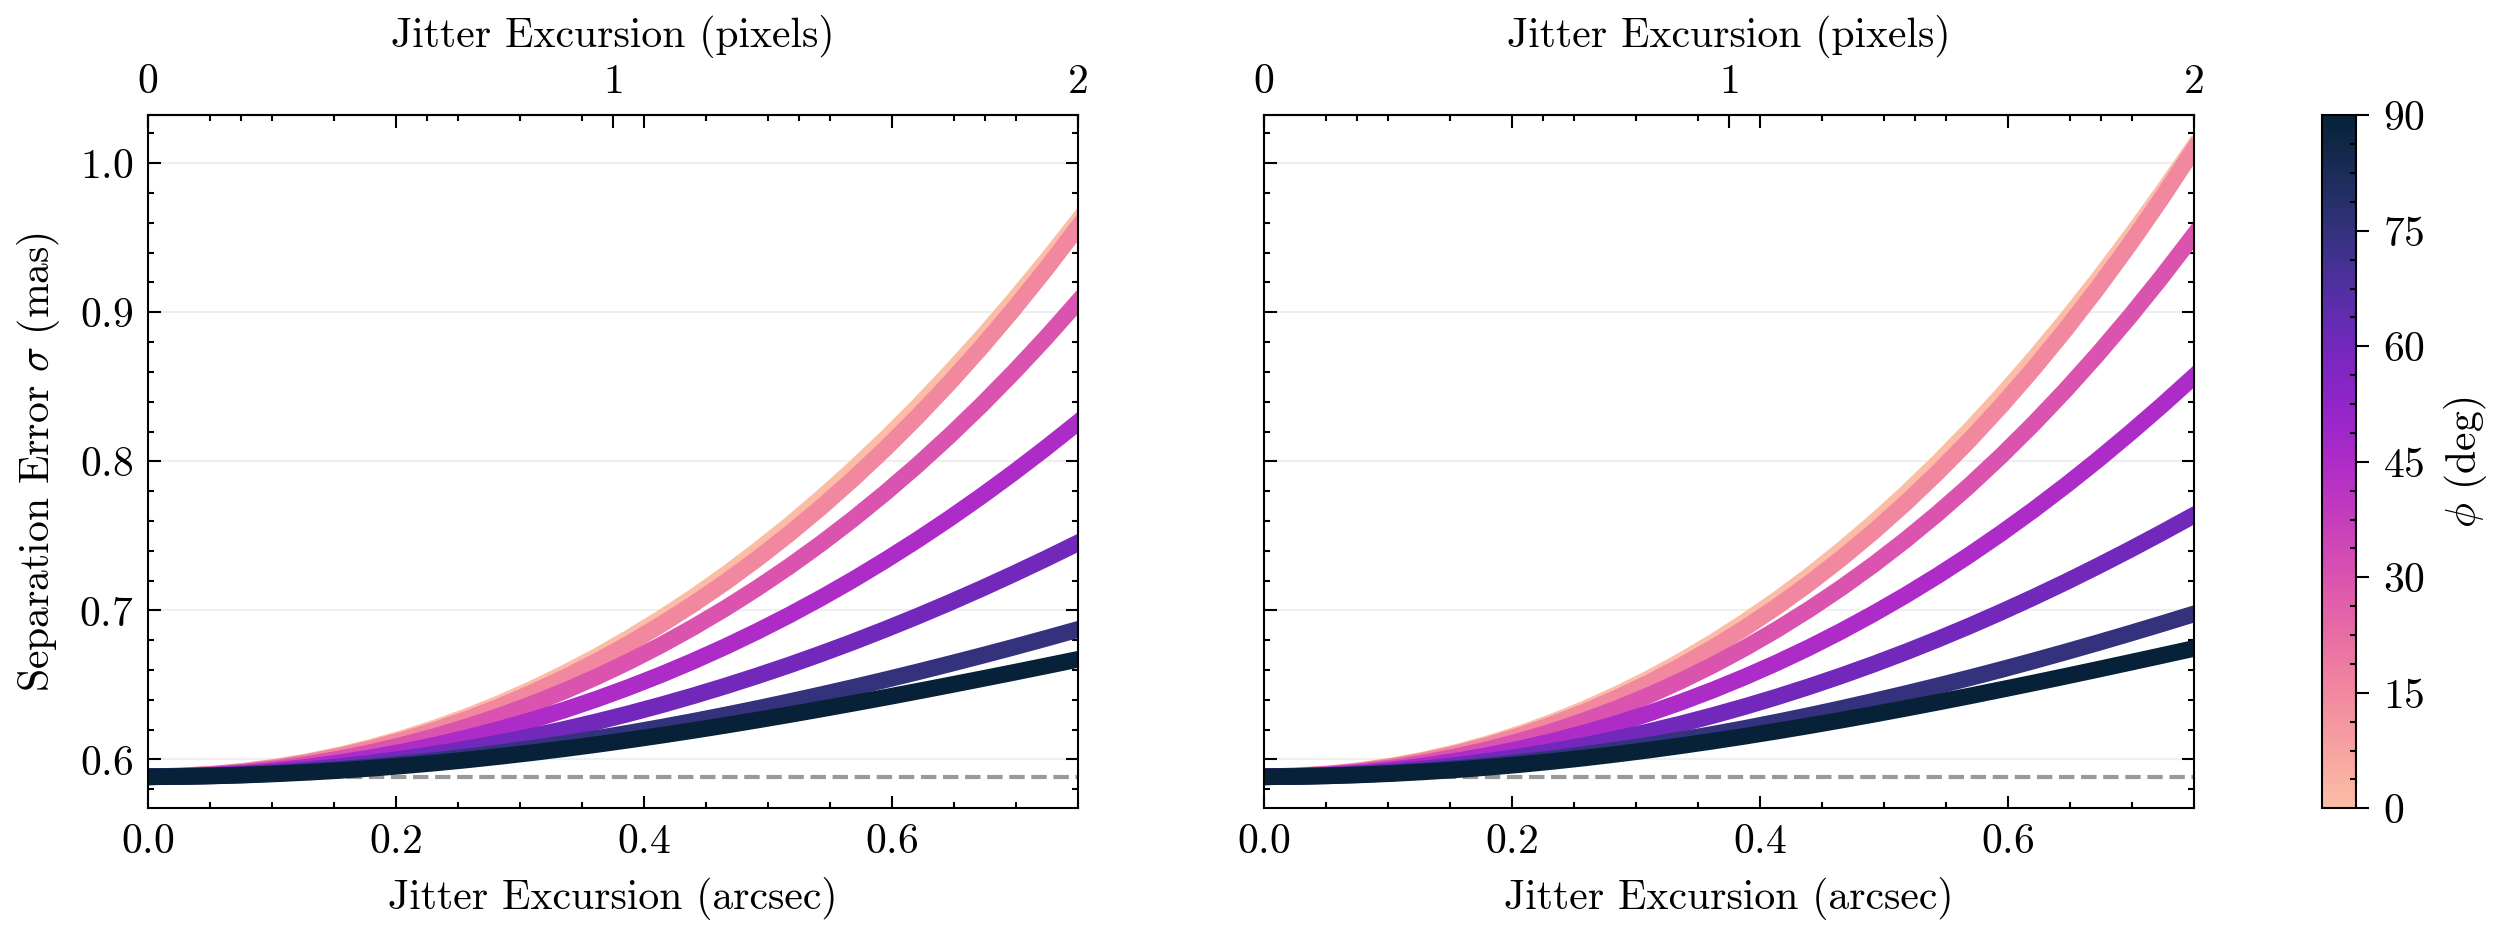

In [54]:
det_pscale = 0.375
mags = test_mags
angs = test_angs
colors = ito_seven
markers = ['o', 's', 'd', '^', 'v', '<', '>']
baseline = 0.5883658744979262

# cmap = plt.get_cmap(cmr.)

fig, ax = plt.subplots(1, 2, figsize=(11, 3), sharey=True,)

cmap = mpl.colormaps['cmr.bubblegum_r']
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=0, vmax=90))
colors = cmap(angs/90)

for i, seps in enumerate([seps_lin, seps_shm]):

    # baseline
    if baseline is not None:
        ax[i].axhline(baseline, linestyle='--', c='k', alpha=0.4, label='No Jitter', linewidth=1)

    for sep, ang, c, m in zip(seps.T, angs, colors, markers):
        ax[i].plot(mags, 1000 * sep, label=r"$\phi\,=\,$"+f"{ang:.0f}", color=c, marker=None, linewidth=4)
        # ax[i].plot(mags, 1000 * sep, label=r"$\phi\,=\,$"+f"{ang:.0f}", color=c, marker=m)

    # Add secondary x-axis scale showing units of pixels
    ax2 = ax[i].secondary_xaxis('top', functions=(lambda x: x/det_pscale, lambda x: x*det_pscale))
    ax2.set(
        xlabel='Jitter Excursion (pixels)',
        xticks=[0, 1., 2.]
        )
    ax[i].grid(True, alpha=0.2, linestyle='-', axis='y')

ax[0].set(
    xlabel='Jitter Excursion (arcsec)',
    ylabel=r'Separation Error $\sigma$ (mas)',
    xlim=(0, mags.max()),
    # ylim=(0, None),
)
ax[1].set(
    xlabel='Jitter Excursion (arcsec)',
    # ylabel=r'Separation Error $\sigma$ (mas)',
    xlim=(0, mags.max()),
    # ylim=(None, 3.15),
)

fig.colorbar(sm, ax=ax, ticks=angs, label=r"$\phi$ (deg)").ax.tick_params(direction='out')


# ax.axvline(x=det_pscale, linestyle='-', color='k', alpha=0.3, linewidth=0.5)

# ax.tick_params(direction='in')
# ax2.tick_params(direction='in')
# ax[0].legend()

# ax[0].grid?
# plt.savefig(f"figs/{title}_results.pdf", dpi=500, bbox_inches='tight')
plt.show()

# Normal Model

In [12]:
def fwhm_to_det(fwhm, shear):
    return (1 - shear)**2 * (fwhm/2.35482)**4

def det_to_fwhm(det, shear):
    return 2.35482 * (det / (1 - shear)**2) ** 0.25

In [13]:
# Marginal params
params = [
    'separation',
    'position_angle',
    'x_position',
    'y_position',
    'log_flux',
    'contrast',
    'Jitter.r',
    'Jitter.shear',
    'Jitter.phi',
    'aperture.coefficients',
    # 'wavelengths',
    # 'psf_pixel_scale',
]

det_pscale = models["norm"].psf_pixel_scale
oversample = models["norm"].oversample
kernel_size = models["norm"].Jitter.kernel_size

phis = np.linspace(0, 90, 7)
shears = np.array([0, 0.3, 0.7])

def powspace(start, stop, power, num):
    start = np.power(start, 1/float(power))
    stop = np.power(stop, 1/float(power))
    return np.power( np.linspace(start, stop, num=num), power) 

rs = powspace(1e-7, fwhm_to_det(1.01*det_pscale, shears[0]), 2, 30)

# Bar sizes
# fwhms = np.linspace(0.1, 3 * det_pscale, 5)

# cov_fns["norm"](models["norm"], np.round(datas["norm"]), params)


In [96]:
seps = []
fwhms = []
kernels = []

for shear_idx, shear in enumerate(shears):
    model = models["norm"].set("detector.Jitter.shear", shear)

    for r_idx, r in tqdm(enumerate(rs), total=len(rs)):
        fwhm = det_to_fwhm(r, shear)
        fwhms.append(fwhm)
        model = model.set("detector.Jitter.r", r)

        for phi_idx, phi in enumerate(phis):        
            # skipping over different angles for shear = 0
            if shear_idx == 0 and phi_idx != 0:
                sep = np.nan
            else:
                model = model.set("detector.Jitter.phi", phi)
                data = model.model()
                
                cov = cov_fns["norm"](model, np.round(data), params)
                sep = np.sqrt(np.abs(cov[0, 0]))
                if phi_idx == 0:
                    if r == rs.max():
                        kernels.append(model.Jitter.generate_kernel(det_pscale/oversample))
                # plt.imshow(model.Jitter.generate_kernel(det_pscale))
                # plt.title(f"{shear}, {phi}, {r:.2e}, {fwhm}")
                # plt.show()
                
            # covs.append(cov)
            seps.append(sep)
            # print(sep)
        
seps = np.array(seps).reshape(len(shears), len(rs), len(phis))
fwhms = np.array(fwhms).reshape(len(shears), len(rs))

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [99]:
# np.save("files/seps/seps_norm.npy", seps)
# np.save("files/seps/kernels.npy", kernels)
# np.save("files/seps/fwhms.npy", fwhms)

In [14]:
seps_norm = np.load("files/seps/seps_norm.npy")
kernels = np.load("files/seps/kernels.npy")
fwhms = np.load("files/seps/fwhms.npy")

In [17]:
# baseline = 0.5883658744979262

# cmap = mpl.cm.get_cmap('cmr.gem')
# sm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=0, vmax=90))
# colors = cmap(phis/90)

# for i, shear in enumerate(shears):

#     fig, (ax, axe) = plt.subplots(1, 2, figsize=(9.5, 3))
#     ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 2))

#     # colors = [(0, 151/256, 54/256), (238/256, 42/256, 53/256), 'k']#(192/256, 147/256, 0)]

#     for sep, phi, c in zip(seps_norm[i].T, phis, colors):
#         if shear == 0:
#             label = None
#             c = 'k'
#         else:
#             label = label=r"$\phi\,=$" +f" {phi:.0f}"
#         ax.plot(rs, 1000 * sep, label=r"$\phi\,=\,$"+f"{ang:.0f}", color=c, marker=None, linewidth=4)
#     ax.set(
#         # title=shear,
#         xlabel=r'det$\,\Sigma$',
#         ylabel=r'Separation Error $\sigma$ (mas)',
#         ylim=(baseline-0.01, 0.8),
#         xlim=(0, rs.max()),
#     )
#     ax2 = ax.secondary_xaxis('top', functions=(lambda r: det_to_fwhm(r, shear), lambda fwhm: fwhm_to_det(fwhm, shear)))
#     # ax2 = ax.secondary_xaxis('top', functions=(lambda x: x/det_pscale, lambda x: x*det_pscale))
#     ax2.set(
#         xlabel='FWHM of semi-major axis (arcsec)',
#         xticks=np.round(2*np.linspace(0, 1, 5)**.25 * det_to_fwhm(rs.max(), shear), 1)/2,
#         )
#     # ax.axvline(x=fwhm_to_det(det_pscale, shear), linestyle=(0, (3, 1, 1, 1, 1, 1)), color=(192/256, 147/256, 0), alpha=1, linewidth=1, label='1 Pix')

#     ax.text(0.61, 0.95, f"Shear: {shear}", transform=ax.transAxes, ha='right', va='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
#     ax.axhline(baseline, linestyle='--', c='k', alpha=0.4, label='No Jitter', linewidth=1)
#     # ax.text(0.01, 0.06, 'NO JITTER', transform=ax.transAxes, font='monospace', size=7, style='oblique')

#     # ax.grid(True, alpha=0.5, linestyle='--')
#     if shear != 0:
#         fig.colorbar(sm, ax=ax, ticks=angs, label=r"$\phi$ (deg)").ax.tick_params(direction='out')


#     extent = np.array([-kernel_size/2, kernel_size/2, -kernel_size/2, kernel_size/2]) * det_pscale / oversample
#     c=axe.imshow(
#         kernels[i],
#         cmap='cmr.arctic',
#         # cmap='YlGnBu_r',
#         origin='lower',
#         extent=extent,
#         )
#     axe.set(
#         # title='Convolution Kernel',
#         xlabel=r'$x$ (arcsec)',
#         ylabel=r'$y$ (arcsec)',
#         xticks=np.linspace(-0.4, 0.4, 5),
#         yticks=np.linspace(-0.4, 0.4, 5),
#     )
#     max_fwhm = det_to_fwhm(rs.max(), shear)
#     # axe.text(1.5, 0.95, f"FWHM: {max_fwhm:.2f}as", transform=ax.transAxes, ha='right', va='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
#     axe.hlines(0, -max_fwhm/2, max_fwhm/2, colors='violet', linestyles='solid', label='FWHM', linewidth=3)
#     fig.colorbar(c, ax=axe, label='Kernel Value').ax.tick_params(direction='out')
#     axe.legend(labelcolor='white', facecolor='k')
#     # plt.savefig(f'figs/gaussian_jitter_{shear}.pdf', bbox_inches='tight')
#     plt.show()


In [82]:
(4 + 1.5)/2

2.75

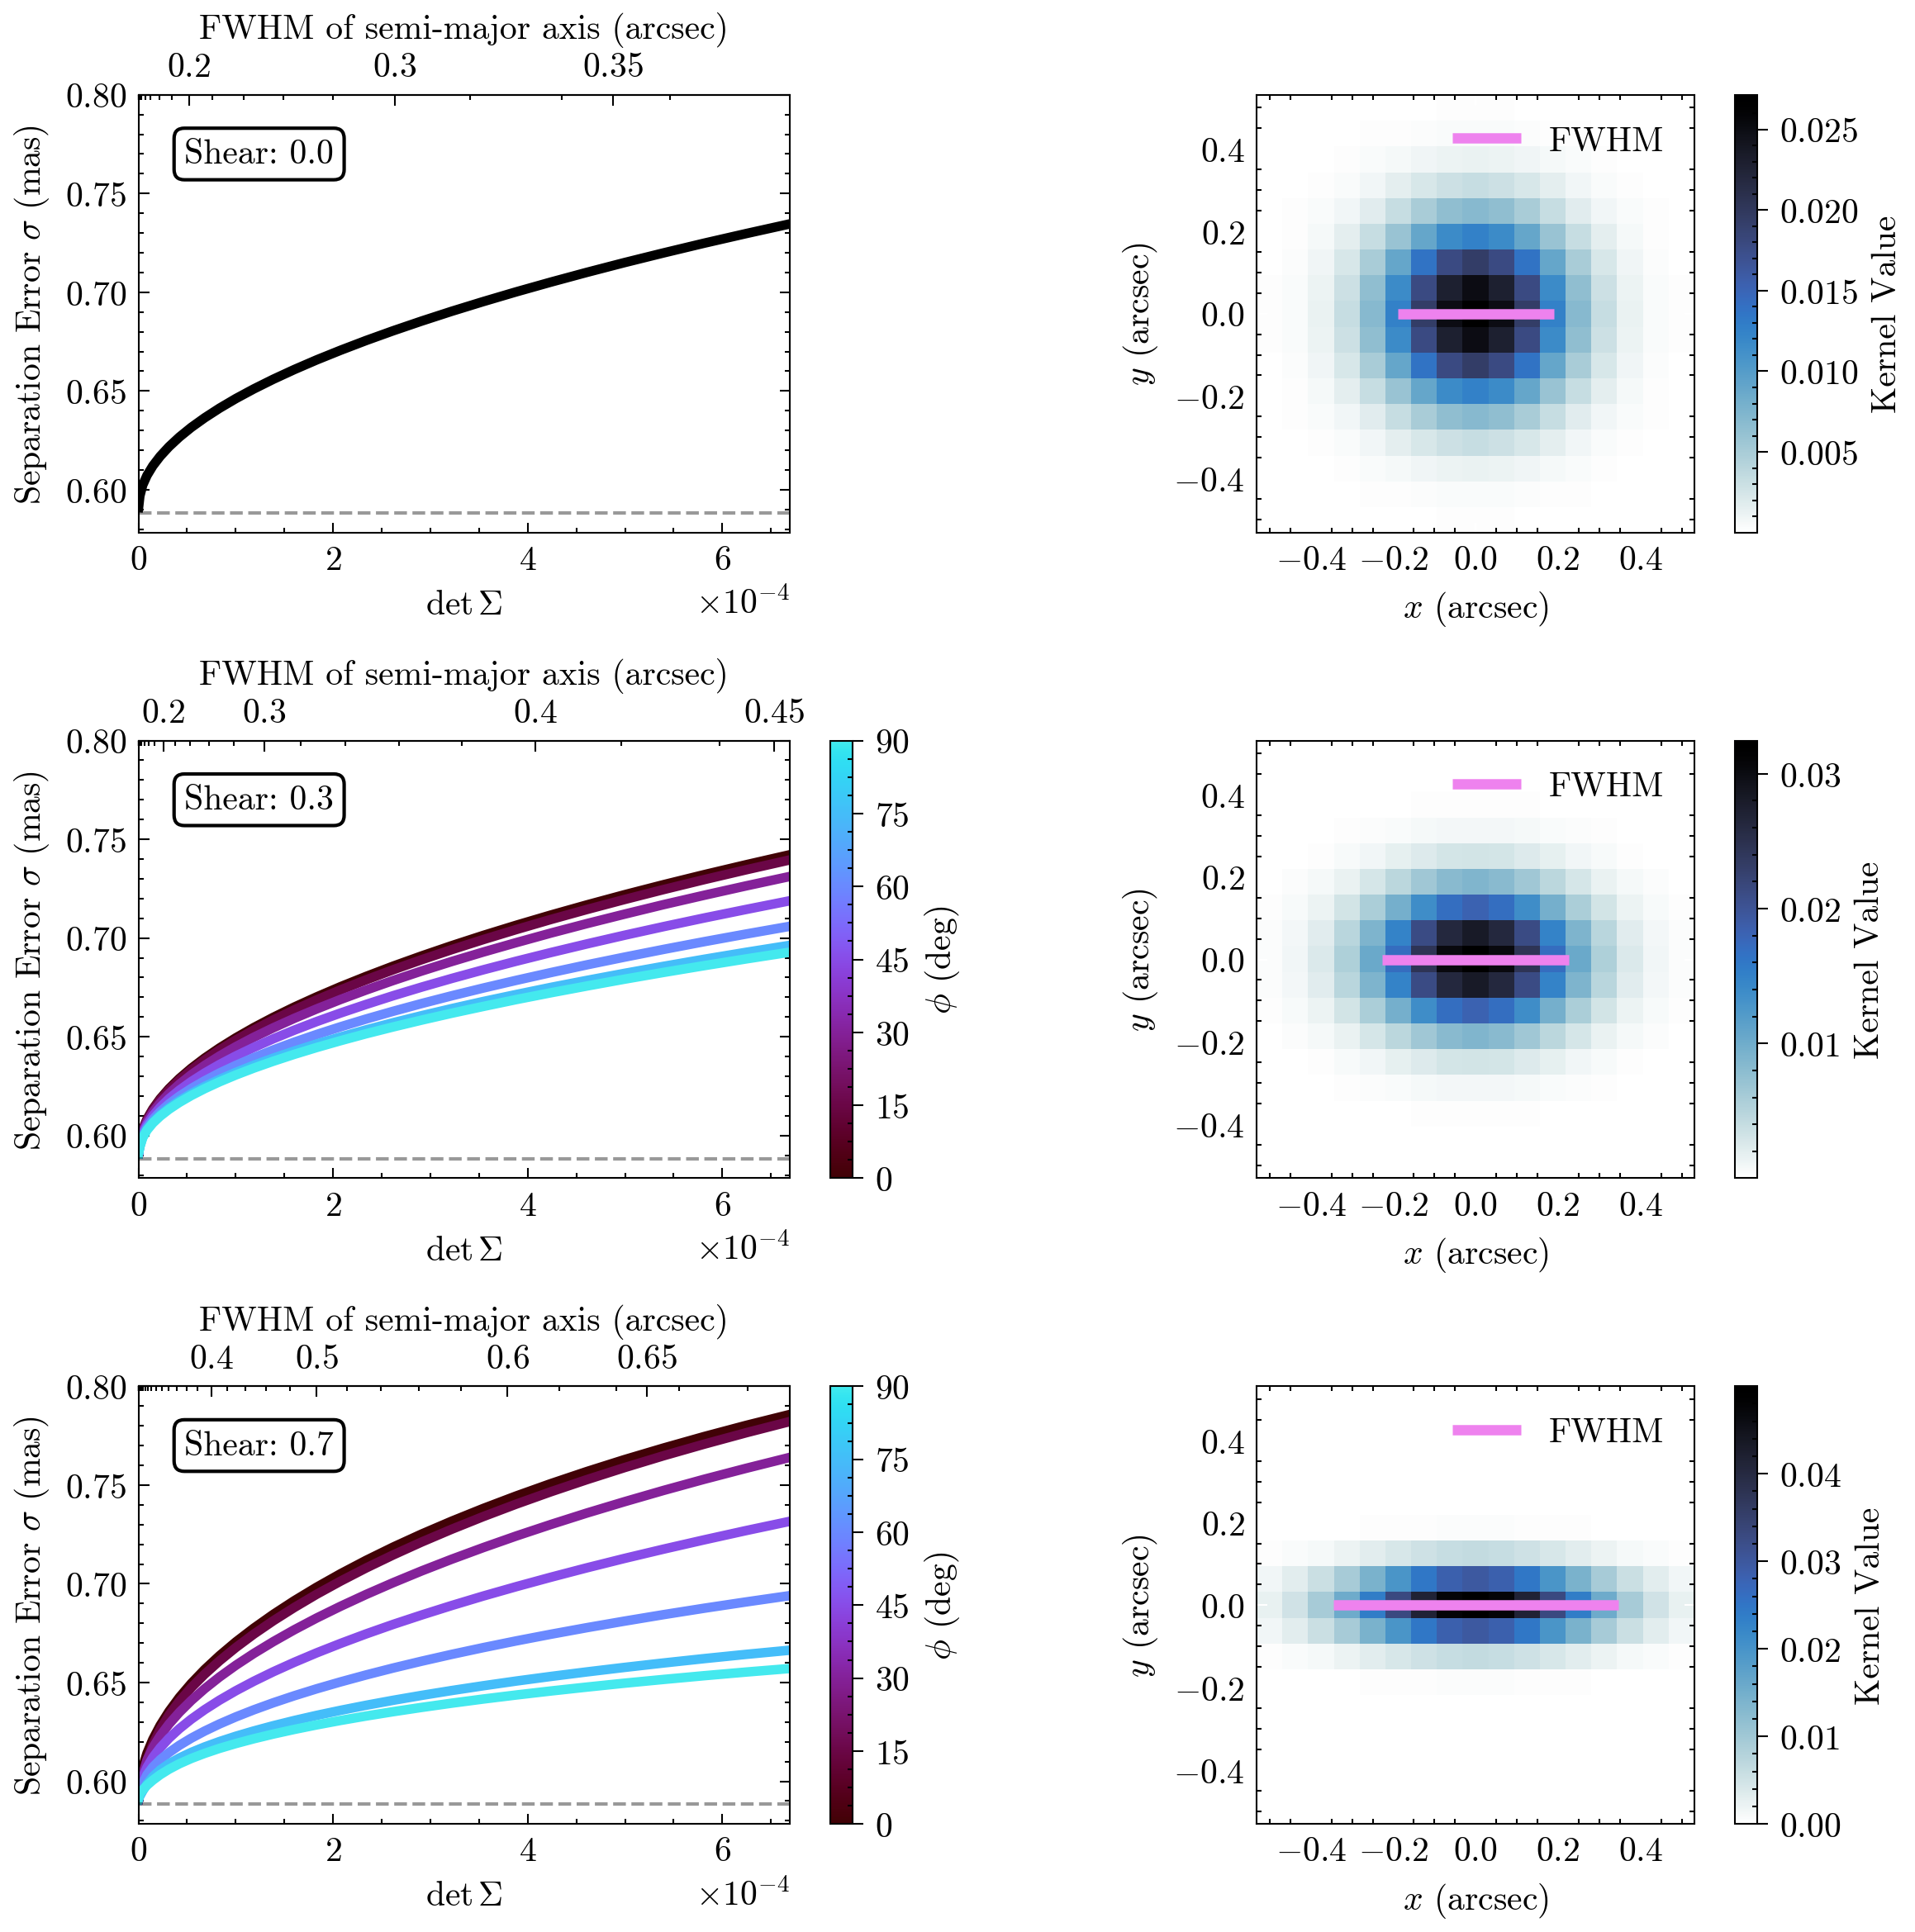

In [89]:
baseline = 0.5883658744979262

cmap = mpl.colormaps['cmr.gem']
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=0, vmax=90))
colors = cmap(phis/90)

fig, axes = plt.subplots(len(shears), 2, figsize=(8, 8), sharey='col')

for i, shear in enumerate(shears):
    ax, axe = axes[i]
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 2))
    ax.tick_params(axis='x', which='both', top=False)

    for sep, phi, c in zip(seps_norm[i].T, phis, colors):
        if shear == 0:
            label = None
            c = 'k'
        else:
            label = label=r"$\phi\,=$" + f" {phi:.0f}"
        ax.plot(rs, 1000 * sep, label=label, color=c, marker=None, linewidth=2.75)
    ax.set(
        xlabel=r'det$\,\Sigma$',
        ylabel=r'Separation Error $\sigma$ (mas)',
        ylim=(baseline-0.01, 0.8),
        xlim=(0, rs.max()),
    )

    ax.text(0.3, 0.9, f"Shear: {shear}", transform=ax.transAxes, ha='right', va='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
    ax.axhline(baseline, linestyle='--', c='k', alpha=0.4, label='No Jitter', linewidth=1)

    if shear == 0:
        cbar = fig.colorbar(sm, ax=ax)
        cbar.ax.set_visible(False)  # Hide the colorbar visually
    else:
        cbar = fig.colorbar(sm, ax=ax, ticks=angs, label=r"$\phi$ (deg)").ax.tick_params(direction='out')


    extent = np.array([-kernel_size/2, kernel_size/2, -kernel_size/2, kernel_size/2]) * det_pscale / oversample
    c = axe.imshow(
        kernels[i],
        cmap='cmr.arctic_r',
        origin='lower',
        extent=extent,
    )
    axe.set(
        xlabel=r'$x$ (arcsec)',
        ylabel=r'$y$ (arcsec)',
        xticks=np.linspace(-0.4, 0.4, 5),
        yticks=np.linspace(-0.4, 0.4, 5),
    )
    axe.tick_params(color="white")
    max_fwhm = det_to_fwhm(rs.max(), shear)
    axe.hlines(0, -max_fwhm/2, max_fwhm/2, colors='violet', linestyles='solid', label='FWHM', linewidth=3)
    fig.colorbar(c, ax=axe, label='Kernel Value').ax.tick_params(direction='out')
    axe.legend(labelcolor='k', framealpha=1., facecolor='k', shadow=True)

# Secondary axes

# First subplot
ax00 = axes[0][0].secondary_xaxis('top', functions=(lambda r: det_to_fwhm(r, shears[0]), lambda fwhm: fwhm_to_det(fwhm, shears[0])))
ax00.set_xticks([0.2, 0.3, 0.35])  # Custom major xticks
ax00.set_xticklabels([r'$0.2$', r'$0.3$', r'$0.35$'])  # Custom labels for major ticks
ax00.minorticks_on()  # Enable minor ticks
ax00.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))  # 5 minor ticks between major ticks
ax00.set_xlabel('FWHM of semi-major axis (arcsec)')

# Second subplot
ax11 = axes[1][0].secondary_xaxis('top', functions=(lambda r: det_to_fwhm(r, shears[1]), lambda fwhm: fwhm_to_det(fwhm, shears[1])))
ax11.set_xticks([0.2, 0.3, 0.4, 0.45])  # Custom major xticks
ax11.set_xticklabels([r'$0.2$', r'$0.3$', r'$0.4$', r'$0.45$'])  # Custom labels for major ticks
ax11.minorticks_on()  # Enable minor ticks
ax11.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))  # 5 minor ticks between major ticks
ax11.set_xlabel('FWHM of semi-major axis (arcsec)')

# First subplot
ax22 = axes[2][0].secondary_xaxis('top', functions=(lambda r: det_to_fwhm(r, shears[2]), lambda fwhm: fwhm_to_det(fwhm, shears[2])))
ax22.set_xticks([0.4, 0.5, 0.6, 0.65])  # Custom major xticks
ax22.set_xticklabels([r'$0.4$', r'$0.5$', r'$0.6$', r'$0.65$'])  # Custom labels for major ticks
ax22.minorticks_on()  # Enable minor ticks
ax22.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))  # 5 minor ticks between major ticks
ax22.set_xlabel('FWHM of semi-major axis (arcsec)')

plt.tight_layout()
plt.show()


# Model Cross-Fitting

In [70]:
def run_grad_desc(
        model,
        data,
        params,
        optimisers: dict,
        loss_func,
        iters=100,
        plot=False,
        verbose=True,
        eps=3e-4, # termination condition
        ):
    """
    Run gradient descent on a model.
    """

    # run gradient descent
    optim, opt_state = zdx.get_optimiser(model, params, optimisers)
    losses, models_out = [], []

    if verbose:
        t = tqdm(range(iters), desc='Gradient Descent')
    else:
        t = range(iters)
        
    for i in t: 

        # for termination condition
        last_params = model.get(params)

        loss, grads = loss_func(model, np.round(data))

        # print(grads)

        updates, opt_state = optim.update(grads, opt_state)
        model = zdx.apply_updates(model, updates)

        models_out.append(model)
        losses.append(loss)

        # if np.isnan(np.array(grads.get(params))).sum() != 0:
        #     raise ValueError("NaN gradient")
        # if np.isneginf(np.array(grads.get(params))).sum() != 0:
        #     raise ValueError("Neginf gradient")
        
        if verbose:
            t.set_description("Loss: {:.6e}".format(loss)) # update the progress bar

        # Terminating condition
        new_params = model.get(params)  # getting new parameters
        scaled_diffs = jax.tree.map(  
            lambda x, y: np.abs((x - y)/y),
            last_params,
            new_params,
            )
        if np.all(np.array(  # if all parameters have converged
            jax.tree.map(lambda x: np.all(x < eps), scaled_diffs)
            )):
            print("Converged early")
            break

    if plot:
        plt.figure()
        plt.title("Log Poisson Loss")
        plt.xlabel("Epoch")
        plt.plot(range(i+1), losses)
        plt.show()

        plt.figure()
        for param in params:
            param_out = np.array([m.get(param) for m in models_out])
            if param_out.size//iters > 1:
                plt.plot(range(i+1), param_out - param_out[0], label=param)
            else:
                plt.plot(range(i+1), param_out, label=param)
            plt.xlabel("Epoch")
            plt.legend()
            plt.ticklabel_format(style='plain', axis='both', useOffset=False)
            plt.show()


    return models_out[-1]

In [71]:

def scheduler(lr, start, *args):
    shed_dict = {start: 1e100}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e100, shed_dict)


base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)
base_adam = lambda vals: optax.adam(vals)

sgd = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))
adam = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))

In [ ]:
import random
from datetime import datetime
from jax import random as jr

sep_dict = {}
n_realisations = 1

# Gradient descent
common_optimisers = {
    "separation": sgd(8e-8, 0),
    'position_angle': sgd(5e-6, 3),
    'x_position': sgd(3e-8, 0),
    'y_position': sgd(3e-8, 2),
    'log_flux': sgd(1e-8, 0),
    'contrast': sgd(6e-6, 1),
    'aperture.coefficients': sgd(1e-3, 0),
}
    # 'mean_wavelength': adam(1e-2, 20),
    # 'psf_pixel_scale': sgd(3e-11, 0),
    # 'psf_pixel_scale': adam(1e-5, 0),

lin_opts = {
    "jitter_mag": sgd(1.5e-6, 0),
    "jitter_angle": sgd(3e-1, 0),
}

norm_opts = {
    # "Jitter.r": sgd(5e-14, 0),
    "Jitter.shear": sgd(4e-5, 0),
    "Jitter.phi": sgd(1e0, 0),
}


for model_key in tqdm(models.keys(), desc="Models"):

    if model_key == "norm":
        optimisers = {**common_optimisers, **norm_opts}
    else:
        optimisers = {**common_optimisers, **lin_opts}

    model = models[model_key]
    loglike_fn = loglike_fns[model_key]

    @zdx.filter_jit
    @zdx.filter_value_and_grad(list(optimisers.keys()))
    def loss_func(model, data):
        return -loglike_fn(model, data)
        # # model_array = model.jitter_model()
        # # return -np.nansum(jsp.stats.poisson.logpmf(data, model_array))
        # # return -loglike_fns[model.jitter_shape](model, data)
        # prior = prior_fn(model)
        # likelihood = np.nansum(jsp.stats.poisson.logpmf(np.round(data), model.jitter_model()))
        # return -(likelihood + prior)

    for data_key in tqdm(datas.keys(), desc='Data Arrays'):
        data = datas[data_key]
        sep_values = np.array([], dtype=np.float64)

        if data_key == "norm":
            continue

        if model_key != "norm":
            continue
        
        for i in tqdm(range(n_realisations), desc='Noise Realisations'):

            noisy_data = jr.poisson(
                jr.PRNGKey(random.randint(0, int(1e8))), 
                data,
                )

            gd_model = run_grad_desc(
                model,
                noisy_data,
                list(optimisers.keys()),
                optimisers=list(optimisers.values()),
                iters=100,
                loss_func=loss_func,
                plot=True,
                # verbose=True,
                # eps=3e-4,
                eps=1e-5,
            )

            raise ValueError("Stop here")

            sep_values = np.append(sep_values, gd_model.separation)

        sep_dict[f"{model_key}_{data_key}"] = sep_values

current_time = datetime.now().strftime('%d-%m-%Y_%H-%M')
save_str = current_time + f"_{n_realisations:04d}.npy"

# np.save(os.path.join(sep_dict_save_dir, save_str), sep_dict)

Models:   0%|          | 0/3 [00:00<?, ?it/s]

Data Arrays:   0%|          | 0/3 [00:00<?, ?it/s]

Data Arrays:   0%|          | 0/3 [00:00<?, ?it/s]

Data Arrays:   0%|          | 0/3 [00:00<?, ?it/s]

Noise Realisations:   0%|          | 0/1 [00:00<?, ?it/s]

Gradient Descent:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
loglike_fns["lin"](models["lin"], np.round(datas["lin"]))